In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
#Progress bar fix: use callbacks=[TQDMNotebookCallback()] in model.fit
#verbose=0 is also required
import JupyterProgbarLogger as Logger
from tqdm import tqdm_notebook as tqdm
from kerastuner.tuners import RandomSearch

from time import time
import numpy as np
import random
import matplotlib.pyplot as plt

import h5py

In [11]:
BATCH_SIZE=32
DATA_AMOUNT=300000

In [3]:
file_path = "images_raw_doric_round1.h5"
with h5py.File(file_path,'r') as f:
    labels = f['/labels'][:DATA_AMOUNT]
    data = f['/frames/raw'][:DATA_AMOUNT]
data = data[(labels>=0)]
labels = labels[(labels>=0)]
if len(data.shape) < 4:
    data=data[...,None]
train_data=data[:int(DATA_AMOUNT*3/4)]
train_labels=labels[:int(DATA_AMOUNT*3/4)]
val_data=data[int(DATA_AMOUNT*3/4):int(DATA_AMOUNT*7/8)]
val_labels=labels[int(DATA_AMOUNT*3/4):int(DATA_AMOUNT*7/8)]
test_data=data[int(DATA_AMOUNT*7/8):DATA_AMOUNT]
test_labels=labels[int(DATA_AMOUNT*7/8):DATA_AMOUNT]

In [4]:
# old-fashioned convnet for flip detection...
def build_model(
                input_shape=(80, 80, 1),
                stride_length=(1, 1),
                kernel=(4, 4),
                kernel_initializer='glorot_uniform',
                activation=layers.Activation('relu'),
                dense_activation=layers.Activation('relu'),
                output_activation=layers.Activation('softmax'),
                batch_momentum=.999,
                combine=True,
                padding='valid',
                batch_norm=False
            ):
    nfilters=[4,8,16,32]
    inputs = layers.Input(shape=input_shape)
    x = inputs

    conv_parameters = {
        'padding': padding,
        'strides': stride_length,
        'kernel_initializer': kernel_initializer
    }

    # encode net
    for filters in nfilters:
        x = layers.Conv2D(filters, kernel, **conv_parameters)(x)
        x = layers.BatchNormalization(momentum=batch_momentum)(x)
        x = activation(x)
        x = layers.MaxPooling2D((2, 2), padding=padding)(x)
    #x = layers.Conv2D(1, (1, 1))(x)
    #x = activation(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(46)(x)
    output = output_activation(x)

    model = keras.models.Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=1e-4,
            momentum=0.9,
            nesterov=True,
            decay=1e-6
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
model = build_model()

In [13]:
history = model.fit(data,
                    labels,
                    epochs=10,
                    verbose=0,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_data,val_labels),
                    callbacks=[Logger.JupyterProgbarLogger()]
                   )

Epoch 1/10


Metrics: loss: 2.9178 - accuracy: 0.1613 - val_loss: 2.4434 - val_accuracy: 0.3241
Epoch 2/10


Metrics: loss: 2.1607 - accuracy: 0.3583 - val_loss: 1.9461 - val_accuracy: 0.4312
Epoch 3/10


Metrics: loss: 1.8667 - accuracy: 0.4242 - val_loss: 1.7333 - val_accuracy: 0.4698
Epoch 4/10


Metrics: loss: 1.7300 - accuracy: 0.4532 - val_loss: 1.6317 - val_accuracy: 0.4917
Epoch 5/10


Metrics: loss: 1.6541 - accuracy: 0.4707 - val_loss: 1.5834 - val_accuracy: 0.4977
Epoch 6/10


Metrics: loss: 1.6028 - accuracy: 0.4822 - val_loss: 1.5403 - val_accuracy: 0.5009
Epoch 7/10


Metrics: loss: 1.5659 - accuracy: 0.4909 - val_loss: 1.5890 - val_accuracy: 0.4859
Epoch 8/10


Metrics: loss: 1.5387 - accuracy: 0.4990 - val_loss: 1.4705 - val_accuracy: 0.5248
Epoch 9/10


Metrics: loss: 1.5178 - accuracy: 0.5032 - val_loss: 1.4439 - val_accuracy: 0.5251
Epoch 10/10


Metrics: loss: 1.5004 - accuracy: 0.5065 - val_loss: 1.4697 - val_accuracy: 0.5227


In [60]:
def accuracy(predictions, answers):
    accs = np.zeros(len(answers))
    for i in range(0,len(answers)):
        if(predictions[i]==answers[i]):
            accs[i]=1
    return np.mean(accs)

In [67]:
predicts = np.argmax(model.predict(test_data),1)

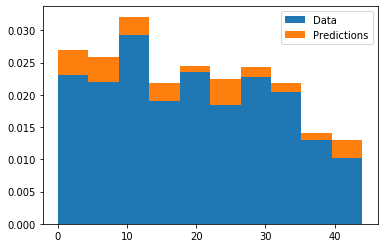

In [61]:
plt.hist((labels,np.argmax(predicts,1)), density=True, histtype='bar', stacked=True, label = ("Data","Predictions"))
plt.legend()
plt.show()

In [66]:
accuracy(np.argmax(predicts,1),test_labels)

0.5163768270564387

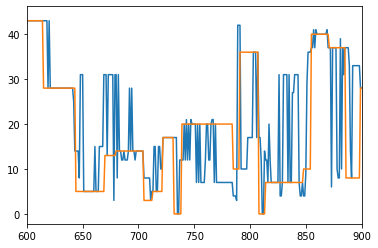

In [72]:
plt.plot(predicts)
plt.plot(test_labels)
plt.xlim(600,900)
plt.show()